# Distribucion de eventos y generacion de señal

Se creara un Script de python para simular una cadena de eventos con una distribucion diseñada

### Importacion de librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Modelo de pulso

In [2]:
# Definición de la forma del pulso
def radiation_event(t, A, t_0, tau_D, tau_R):
    return (A * ((np.exp(-(t - t_0) / tau_D) - np.exp(-(t - t_0) / tau_R)))) * np.heaviside(t - t_0, 1)

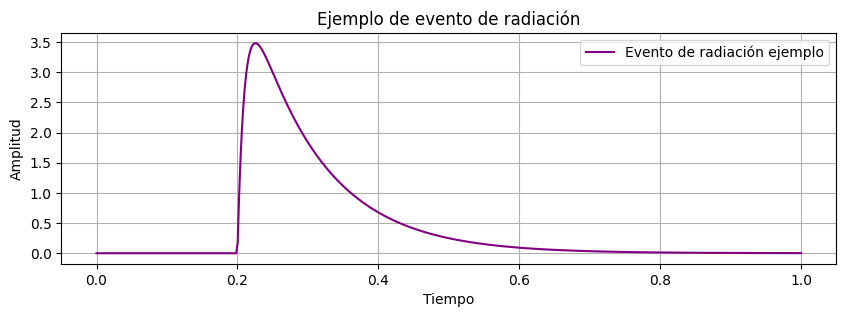

In [3]:
# Ejemplo de un evento de radiación
example_t = np.linspace(0, 1, 500)
example_A = 5  # Amplitud
example_t_0 = 0.2  # Tiempo inicial
example_tau_D = 0.1  # Decaimiento
example_tau_R = 0.01  # Subida
example_pulse = radiation_event(example_t, example_A, example_t_0, example_tau_D, example_tau_R)

plt.figure(figsize=(10, 3))
plt.plot(example_t, example_pulse, label='Evento de radiación ejemplo', color='purple')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Ejemplo de evento de radiación')
plt.legend()
plt.grid()
plt.show()

### Simulacion de los pulsos

In [4]:
# Parámetros de la simulación
num_pulsos = 100000  # Número total de pulsos
tiempo = np.linspace(0, 1, 500)  # Eje de tiempo para cada pulso

# Definir parámetros de las distribuciones
lambda_poisson = 3
media_gauss = 25
sigma_gauss = 5

### Metodo de generacion de funciones de densidad de probabilidad y acumulada

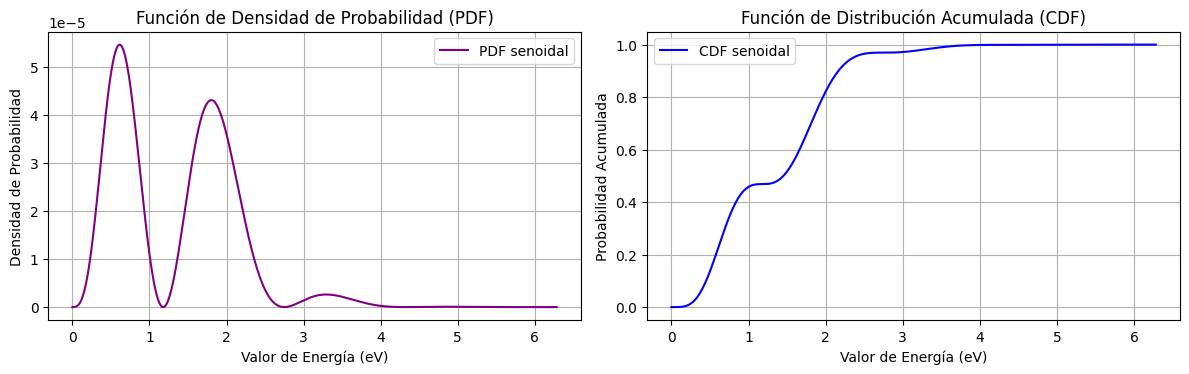

In [5]:
# Generar la función de densidad de probabilidad (PDF) senoidal
x = np.linspace(0, 2 * np.pi, 100000)  # Rango de valores
pdf_senoidal = np.abs(np.sin(4 * x) + 1) * x**3 *np.exp(-3*x)  # PDF senoidal

# Normalizar la PDF para que su área sea 1 (función de densidad de probabilidad válida)
pdf_senoidal /= np.sum(pdf_senoidal)

# Calcular la CDF a partir de la PDF (suma acumulada)
cdf_senoidal = np.cumsum(pdf_senoidal)
cdf_senoidal /= cdf_senoidal[-1]  # Normalizar la CDF para que termine en 1

# Graficar PDF y CDF
plt.figure(figsize=(12, 4))

# Gráfico de la PDF
plt.subplot(1, 2, 1)
plt.plot(x, pdf_senoidal, color='purple', label='PDF senoidal')
plt.xlabel('Valor de Energía (eV)')
plt.ylabel('Densidad de Probabilidad')
plt.title('Función de Densidad de Probabilidad (PDF)')
plt.grid()
plt.legend()

# Gráfico de la CDF
plt.subplot(1, 2, 2)
plt.plot(x, cdf_senoidal, color='blue', label='CDF senoidal')
plt.xlabel('Valor de Energía (eV)')
plt.ylabel('Probabilidad Acumulada')
plt.title('Función de Distribución Acumulada (CDF)')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

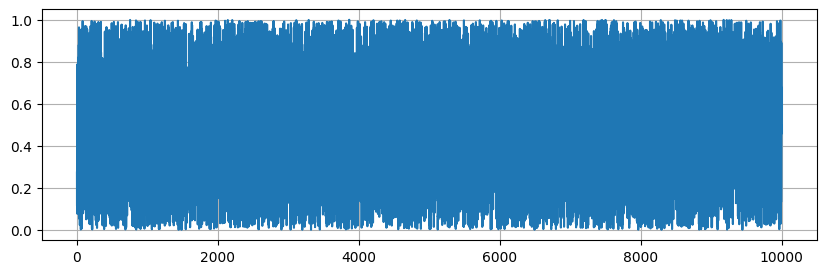

In [6]:
# Generar muestras aleatorias en el intervalo [0, 1] para la CDF
uniform_samples = np.random.uniform(0, 1, 10000)

# Graficar PDF y CDF
plt.figure(figsize=(10, 3))

# Gráfico de la PDF
plt.plot(uniform_samples)
plt.grid()

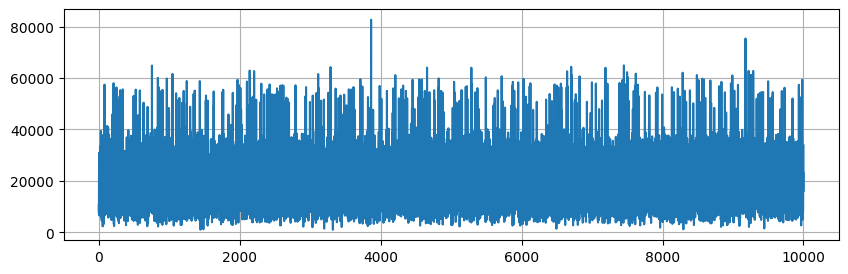

In [7]:
# Encontrar los índices en la CDF correspondientes a las muestras uniformemente distribuidas
indices = np.searchsorted(cdf_senoidal, uniform_samples)

# Graficar PDF y CDF
plt.figure(figsize=(10, 3))

# Gráfico de la PDF
plt.plot(indices)
plt.grid()

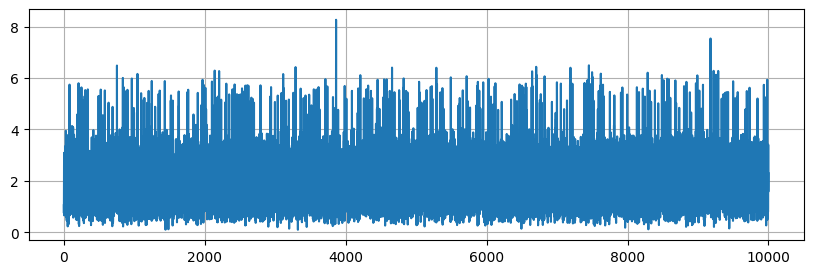

In [8]:
# Mapear los índices a las energías
energy_values = np.linspace(0, 10, 100000)
samples = energy_values[indices]

# Graficar PDF y CDF
plt.figure(figsize=(10, 3))

# Gráfico de la PDF
plt.plot(samples)
plt.grid()

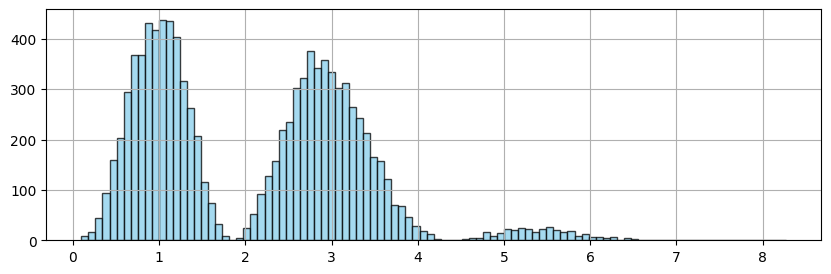

In [9]:
plt.figure(figsize=(10, 3))

plt.hist(samples, bins=100, alpha=0.75, edgecolor='black', color='skyblue')
plt.grid()
plt.show()


### Creacion de funcion Monte Carlo

El **muestreo por aceptación-rechazo** (acceptance-rejection sampling) es un algoritmo utilizado para generar muestras de una distribución de probabilidad que es difícil de muestrear directamente. En lugar de muestrear directamente de la distribución de interés, este método genera muestras de una distribución más fácil de manejar (llamada **distribución propuesta**) y luego las **acepta** o **rechaza** en función de una condición basada en la relación entre la distribución propuesta y la distribución de interés.

### Proceso de muestreo por aceptación-rechazo:

1. **Definir la distribución propuesta**:
   - Elegimos una **distribución propuesta** fácil de muestrear (en este caso, una distribución uniforme). Esta distribución debe ser más simple y fácil de manejar que la distribución de interés.
   - La distribución propuesta, \( g(x) \), debe ser tal que cubra toda la distribución \( f(x) \) de la cual queremos muestrear, multiplicada por una constante de escala, \( M \).

2. **Obtener la constante \( M \)**:
   - Debemos encontrar una constante \( M \) tal que para todas las \( x \), se cumpla la relación \( f(x) \leq M \cdot g(x) \). Esto asegura que la distribución propuesta puede cubrir la de interés, y garantiza que no rechazamos una muestra de forma incorrecta.
   - En nuestro caso, la función de probabilidad de interés \( f(x) \) es una senoidal (después de la normalización).

3. **Generación de muestras**:
   - Generamos una muestra \( x' \) de la **distribución propuesta** \( g(x) \), lo que generalmente se hace utilizando una distribución uniforme o alguna que sea fácil de manejar.
   - Generamos un número aleatorio \( u \) uniformemente distribuido en el rango [0, 1].

4. **Decisión de aceptación/rechazo**:
   - Comparamos el valor \( u \) con la razón de las densidades de probabilidad:
     \[
     u \leq \frac{f(x')}{M \cdot g(x')}
     \]
     Si la desigualdad se cumple, **aceptamos** la muestra \( x' \) y la añadimos a nuestro conjunto de muestras.
   - Si no se cumple la desigualdad, **rechazamos** la muestra y volvemos a generar una nueva propuesta \( x' \).

5. **Repetir el proceso**:
   - Continuamos generando y aceptando/rechazando muestras hasta que tengamos el número deseado de muestras.

### Ejemplo con la distribución senoidal

En el caso de la función de probabilidad senoidal, queremos generar muestras de la distribución de probabilidad senoidal. A continuación te explico cómo se aplica este proceso a nuestro caso:

1. **Distribución de interés**:
   Queremos generar muestras de la función de probabilidad \( f(x) = |\sin(frequency \cdot x)| \), la cual tiene forma de onda senoidal.

2. **Distribución propuesta**:
   Usamos una distribución uniforme \( g(x) \) en el intervalo \([min\_value, max\_value]\), porque es fácil de muestrear (esto significa que cada valor en ese rango tiene la misma probabilidad de ser seleccionado).

3. **Cálculo de \( M \)**:
   Necesitamos encontrar la constante \( M \), que se asegura de que la función senoidal \( f(x) \) esté siempre por debajo de \( M \cdot g(x) \). Como la función \( |\sin(x)| \) está entre 0 y 1, podemos establecer \( M = 1 \), ya que la función uniforme también tiene un valor máximo de 1 (en términos de probabilidad).

4. **Generación de una muestra**:
   - Generamos una muestra \( x' \) aleatoria de la distribución uniforme.
   - Calculamos el valor de la función senoidal \( f(x') = |\sin(frequency \cdot x')| \).
   - Generamos un número aleatorio \( u \) entre 0 y 1.

5. **Decisión de aceptación/rechazo**:
   - Comparamos \( u \) con la razón \( f(x') / M \cdot g(x') \). En este caso, como \( g(x) \) es uniforme, \( g(x') = 1 / (max\_value - min\_value) \), y aceptamos la muestra si:
     \[
     u \leq \frac{|\sin(frequency \cdot x')|}{1 \cdot \frac{1}{max\_value - min\_value}}
     \]
   - Si esta condición se cumple, aceptamos la muestra y la añadimos a nuestro conjunto de datos.

6. **Repetir hasta obtener suficientes muestras**:
   - Este proceso se repite hasta que tengamos suficientes muestras de la distribución senoidal.

Este es el **principio básico** detrás del muestreo por aceptación-rechazo, donde utilizamos una distribución propuesta fácil de muestrear y rechazamos aquellas muestras que no cumplen con las condiciones de la distribución de interés.

Este procedimiento es un **método de muestreo** basado en la **función de distribución acumulada** (CDF) de una función de densidad de probabilidad (PDF) dada. El objetivo es generar muestras que sigan la distribución especificada, en este caso, una función senoidal, de manera eficiente y válida.

### Paso a paso:

1. **Generación de la función senoidal normalizada:**

   ```python
   x = np.linspace(0, 2 * np.pi, num_samples)
   pdf_senoidal = np.abs(np.sin(frequency * x))
   ```

   - **¿Qué hace este paso?**:
     - Genera una secuencia de valores `x` en el intervalo \([0, 2\pi]\) (o lo que se defina por `num_samples`), donde `num_samples` es el número de muestras que queremos generar.
     - Luego, calcula la **función senoidal** de \( \sin(frequency \cdot x) \). Esto genera una onda oscilante.
     - El valor absoluto se aplica a la función senoidal con `np.abs()` para asegurarse de que todos los valores sean positivos, porque las funciones de densidad de probabilidad no pueden ser negativas.

   - **¿Por qué es válido este paso?**:
     - Usar una función senoidal asegura que los valores oscilen, pero tomar el valor absoluto garantiza que no haya valores negativos. Esto es necesario porque la densidad de probabilidad siempre debe ser no negativa.

2. **Normalización de la PDF para que su área total sea 1:**

   ```python
   pdf_senoidal /= np.sum(pdf_senoidal)
   ```

   - **¿Qué hace este paso?**:
     - La **normalización** asegura que la PDF sea válida, es decir, que el área total bajo la curva de la PDF sea igual a 1. La integral de una PDF sobre su dominio debe ser 1, ya que esto representa la certeza de que la variable aleatoria tomará algún valor dentro del dominio.
     - `np.sum(pdf_senoidal)` calcula la suma total de los valores de la PDF, y luego se divide cada valor de la PDF por esta suma.

   - **¿Por qué es válido este paso?**:
     - Este paso asegura que la función se comporta como una verdadera función de densidad de probabilidad. Al normalizarla, se garantiza que su área total será 1, lo que es una condición necesaria para una PDF válida.

3. **Cálculo de la CDF (integración acumulativa):**

   ```python
   cdf_senoidal = np.cumsum(pdf_senoidal)
   cdf_senoidal /= cdf_senoidal[-1]
   ```

   - **¿Qué hace este paso?**:
     - La **CDF** es la **integral acumulada** de la PDF, lo que significa que en cada punto de la CDF, se acumula la probabilidad hasta ese valor de \( x \).
     - `np.cumsum(pdf_senoidal)` calcula la **suma acumulada** de los valores de la PDF, lo que da como resultado la CDF. Es equivalente a integrar la PDF de manera discreta.
     - La normalización con `cdf_senoidal /= cdf_senoidal[-1]` asegura que el valor final de la CDF sea igual a 1, lo que es una propiedad fundamental de la CDF: la probabilidad acumulada de todos los valores posibles debe ser 1.

   - **¿Por qué es válido este paso?**:
     - La **CDF** es una función no decreciente que acumula la probabilidad. La normalización asegura que su valor final sea 1, lo que la convierte en una CDF válida.

4. **Generación de muestras aleatorias uniformemente distribuidas:**

   ```python
   uniform_samples = np.random.uniform(0, 1, num_samples)
   ```

   - **¿Qué hace este paso?**:
     - Se generan **muestras uniformemente distribuidas** en el intervalo \([0, 1]\), que se utilizarán para muestrear la CDF.
     - La idea es que la CDF nos da la probabilidad acumulada, por lo que, al generar números uniformemente distribuidos, podemos encontrar qué valores de la CDF corresponden a esos números aleatorios.

   - **¿Por qué es válido este paso?**:
     - Usar una distribución uniforme es una estrategia estándar en el muestreo de distribuciones no uniformes. La uniformidad asegura que estamos explorando el espacio de manera equitativa.

5. **Encontrar los índices correspondientes en la CDF:**

   ```python
   indices = np.searchsorted(cdf_senoidal, uniform_samples)
   ```

   - **¿Qué hace este paso?**:
     - `np.searchsorted(cdf_senoidal, uniform_samples)` encuentra, para cada valor aleatorio en `uniform_samples`, el **índice** en la CDF donde ese valor se encuentra o lo supera. Este es el proceso clave del muestreo inverso.
     - La idea es que los valores de `uniform_samples` representen probabilidades acumuladas, y buscamos dónde esas probabilidades se corresponden en la CDF.

   - **¿Por qué es válido este paso?**:
     - Este paso implementa el principio de **muestreo inverso**: estamos buscando las posiciones de las probabilidades acumuladas generadas uniformemente dentro de la CDF.

6. **Mapeo de los índices a los valores de energía:**

   ```python
   energy_values = np.linspace(min_value, max_value, num_samples)
   samples = energy_values[indices]
   ```

   - **¿Qué hace este paso?**:
     - `np.linspace(min_value, max_value, num_samples)` genera los valores de energía distribuidos uniformemente en el intervalo \([min\_value, max\_value]\). Esta secuencia de valores corresponde a los valores de la variable aleatoria que estamos muestreando.
     - Luego, `samples = energy_values[indices]` mapea los índices encontrados en la CDF a los valores de energía correspondientes.

   - **¿Por qué es válido este paso?**:
     - Este es el último paso del muestreo inverso. Al mapear los índices de la CDF a los valores de energía, generamos una muestra de la distribución senoidal en el intervalo deseado \([min\_value, max\_value]\).

### Resumen de la validez y el proceso:

- **Muestreo inverso**: Usamos la CDF como una forma de transformar una muestra uniformemente distribuida en una muestra de la distribución deseada (en este caso, una distribución senoidal).
- **Proceso eficiente**: Al calcular la PDF, normalizarla, calcular la CDF y usar la función `np.searchsorted`, podemos generar muestras directamente de la distribución senoidal sin necesidad de realizar un proceso de aceptación-rechazo.
- **Distribución válida**: Todos los pasos aseguran que la función de densidad de probabilidad sea válida (non-negativa y con área total 1), y que la función de distribución acumulada sea correcta (con probabilidad total acumulada igual a 1).

Este método es una manera eficiente y válida de muestrear distribuciones complejas utilizando su CDF.

In [10]:
# Generar alturas con Monte Carlo usando la distribución deseada
def monte_carlo_sample(num_samples):
    """
    Generar muestras Monte Carlo basadas en una distribución bimodal deseada
    """
    # Muchos conteos alrededor de 4 eV (Poissoniana concentrada)
    poisson = np.random.poisson(lam=4, size=int(num_samples * 0.4))
    
    # Un pico significativo en 10 eV (Normal muy estrecha)
    pico_central = np.random.normal(loc=10, scale=0.5, size=int(num_samples * 0.3))

    # Distribución gaussiana entre 15 y 35 eV
    gauss = np.random.normal(loc=25, scale=5, size=int(num_samples * 0.3))

    # Combinar y filtrar valores fuera del rango [1.5, 30]
    distribucion = np.concatenate([poisson, pico_central, gauss])
    distribucion = distribucion[(distribucion >= 1.5) & (distribucion <= 30)]

    return distribucion

def monte_carlo_senoidal(num_samples, amplitude=5, frequency=20, min_value=1.5, max_value=30):
    """
    Generar muestras basadas en una distribución senoidal.
    
    Parameters:
    - num_samples: número de muestras a generar.
    - amplitude: amplitud de la onda senoidal.
    - frequency: frecuencia de la onda senoidal.
    - min_value: valor mínimo de energía.
    - max_value: valor máximo de energía.
    
    Returns:
    - distribucion: muestras generadas a partir de la función senoidal.
    """
    # Generar una secuencia de tiempo o valores en el intervalo [0, 2*pi]
    x = np.linspace(0, 2 * np.pi, num_samples)
    
    # Generar una onda senoidal en el intervalo deseado
    senoide = amplitude * np.sin(frequency * x) + amplitude  # Ajuste de amplitud para asegurar valores positivos
    
    # Mapear la onda senoidal a un rango de energía [min_value, max_value]
    distribucion = np.interp(senoide, (senoide.min(), senoide.max()), (min_value, max_value))
    
    # Filtrar valores fuera del rango deseado
    distribucion = distribucion[(distribucion >= min_value) & (distribucion <= max_value)]
    
    return distribucion

def monte_carlo_senoidal_pdf(num_samples, amplitude=1, frequency=4, min_value=1.5, max_value=30):
    """
    Generar muestras a partir de una función de probabilidad senoidal.
    
    La función de densidad de probabilidad tiene la forma de una onda senoidal.
    
    Parameters:
    - num_samples: número de muestras a generar.
    - amplitude: amplitud de la onda senoidal.
    - frequency: frecuencia de la onda senoidal.
    - min_value: valor mínimo de energía.
    - max_value: valor máximo de energía.
    
    Returns:
    - distribucion: muestras generadas a partir de la función senoidal.
    """
    # Generar la función senoidal normalizada
    x = np.linspace(0, 2 * np.pi, num_samples)
    # pdf_senoidal = np.abs(np.sin(frequency * x)*np.exp(-0.4*x)+1)  # Usar valor absoluto para que sea positiva
    pdf_senoidal = np.abs(np.sin(frequency * x)+1)  # Usar valor absoluto para que sea positiva
    
    # Normalizar la PDF para que su área sea 1 (función de densidad de probabilidad válida)
    pdf_senoidal /= np.sum(pdf_senoidal)
    
    # Mapear x al rango de energías [min_value, max_value]
    energy_values = np.linspace(min_value, max_value, num_samples)
    
    # Generar muestras usando muestreo por aceptación
    samples = []
    while len(samples) < num_samples:
        # Proponer una muestra aleatoria
        proposed_sample = np.random.uniform(min_value, max_value)
        
        # Convertir la muestra a su índice en el vector de energía
        idx = int((proposed_sample - min_value) / (max_value - min_value) * (num_samples - 1))
        
        # Generar un valor aleatorio entre 0 y el valor de la PDF en ese punto
        if np.random.uniform(0, 1) < pdf_senoidal[idx]:
            samples.append(proposed_sample)
    
    return np.array(samples)

def monte_carlo_senoidal_pdf_optimized(num_samples, amplitude=1, frequency=4, min_value=1.5, max_value=30):
    """
    Genera muestras a partir de una función de probabilidad senoidal utilizando muestreo eficiente.
    
    Utiliza el muestreo inverso basado en la función de distribución acumulada (CDF).
    
    Parameters:
    - num_samples: número de muestras a generar.
    - amplitude: amplitud de la onda senoidal.
    - frequency: frecuencia de la onda senoidal.
    - min_value: valor mínimo de energía.
    - max_value: valor máximo de energía.
    
    Returns:
    - distribucion: muestras generadas a partir de la función senoidal.
    """
    # Generar la función senoidal normalizada
    x = np.linspace(0, 2 * np.pi, num_samples)
    # pdf_senoidal = np.abs(np.sin(frequency * x) + 1) * x**2  # Usar valor absoluto para que sea positiva
    pdf_senoidal = np.abs(8*np.exp(-1 * ((x-2)/0.2)**2) + 2*np.exp(-1 * (x-5)**2))  # Usar valor absoluto para que sea positiva
    
    # Normalizar la PDF para que su área sea 1 (función de densidad de probabilidad válida)
    pdf_senoidal /= np.sum(pdf_senoidal)
    
    # Calcular la CDF (integración acumulativa)
    cdf_senoidal = np.cumsum(pdf_senoidal)
    cdf_senoidal /= cdf_senoidal[-1]  # Normalizar la CDF para que termine en 1
    
    # Generar muestras aleatorias en el intervalo [0, 1] para la CDF
    uniform_samples = np.random.uniform(0, 1, num_samples)
    
    # Encontrar los índices en la CDF correspondientes a las muestras uniformemente distribuidas
    indices = np.searchsorted(cdf_senoidal, uniform_samples)
    
    # Mapear los índices a las energías
    energy_values = np.linspace(min_value, max_value, num_samples)
    samples = energy_values[indices]
    
    return samples

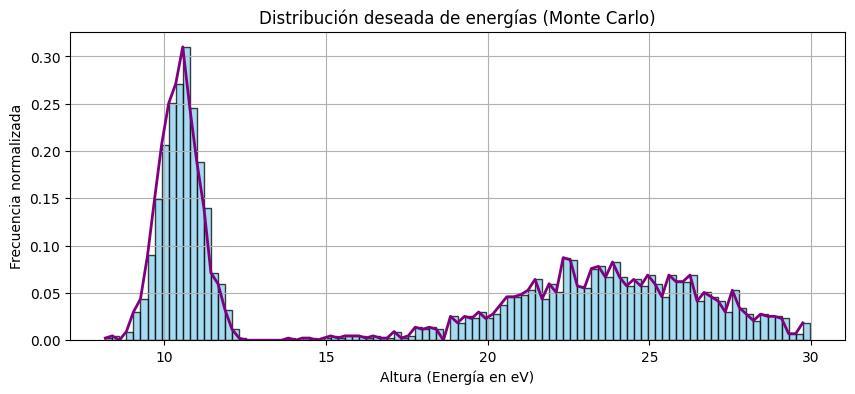

In [13]:
# Generar alturas usando Monte Carlo
# alturas = monte_carlo_sample(num_pulsos)
# alturas = monte_carlo_senoidal_pdf(num_pulsos)
num_pulsos = 2000
alturas = monte_carlo_senoidal_pdf_optimized(num_pulsos)

# Visualizar la distribución deseada (bimodal con Poisson y Gaussiana) en línea continua
plt.figure(figsize=(10, 4))
# Generar un histograma de la distribución sin bins y graficarlo como una línea continua
count, bins, ignored = plt.hist(alturas, bins=100, alpha=0.75, edgecolor='black', color='skyblue', density=True)
# Graficar la distribución de la altura de los pulsos como una línea
plt.plot(bins[:-1], count, color='purple', lw=2)
plt.xlabel('Altura (Energía en eV)')
plt.ylabel('Frecuencia normalizada')
plt.title('Distribución deseada de energías (Monte Carlo)')
plt.grid()
plt.show()


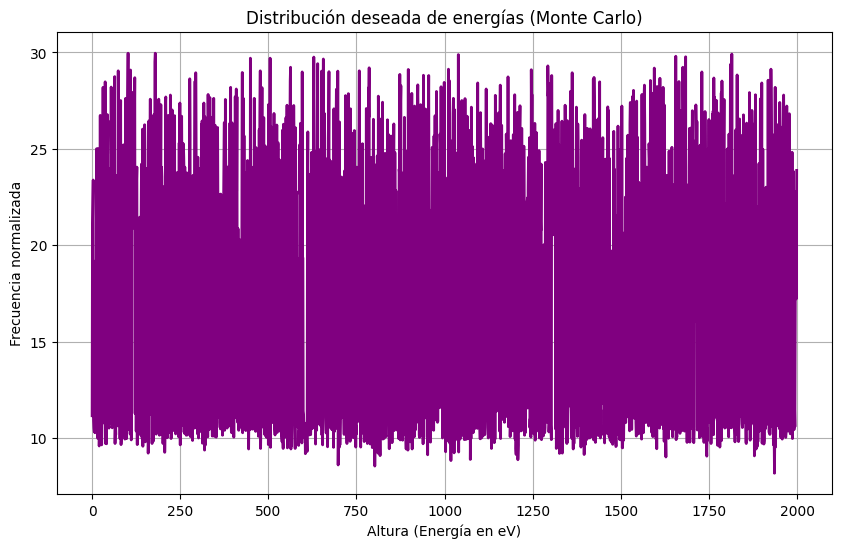

In [14]:
# Visualizar la distribución deseada (bimodal con Poisson y Gaussiana) en línea continua
plt.figure(figsize=(10, 6))
# Generar un histograma de la distribución sin bins y graficarlo como una línea continua
# count, bins, ignored = plt.hist(alturas, bins=100, alpha=0.75, edgecolor='black', color='skyblue', density=True)
# Graficar la distribución de la altura de los pulsos como una línea
plt.plot(alturas, color='purple', lw=2)
plt.xlabel('Altura (Energía en eV)')
plt.ylabel('Frecuencia normalizada')
plt.title('Distribución deseada de energías (Monte Carlo)')
plt.grid()
plt.show()

### Generacion de los pulsos

In [19]:
# Parámetros de los pulsos
tau_D = 0.1  # Constante de tiempo de decaimiento
tau_R = 0.01  # Constante de tiempo de subida

# Generar los pulsos con la forma definida
pulsos = []
for altura in alturas:
    t_0 = np.random.uniform(0.1, 0.2)  # Tiempo de inicio aleatorio para cada pulso
    pulso = radiation_event(tiempo, altura, t_0, tau_D, tau_R)
    pulsos.append(pulso)


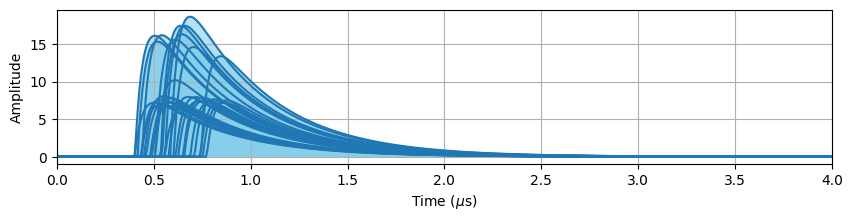

In [29]:
# Visualizar algunos pulsos generados
plt.figure(figsize=(10,2.0))
for i in range(30):  # Mostrar los primeros 5 pulsos
    plt.plot(4 * tiempo, pulsos[i], color='tab:blue',linewidth=1.5) ,# label=f'Pulso {i+1}')
    plt.fill_between(4 * tiempo, pulsos[i], color='skyblue', alpha=0.6)


# Configurar la leyenda y las etiquetas de los ejes
plt.xlabel('Time ($\mu$s) ')
plt.ylabel('Amplitude')
# plt.title('Ejemplo de pulsos generados con la nueva forma')
plt.xlim([0,4])
# plt.legend()
plt.grid(True)
# plt.show()

plt.savefig("output/PulsesDist.pdf", format="pdf", bbox_inches="tight")

### Conteo de pulsos e histograma

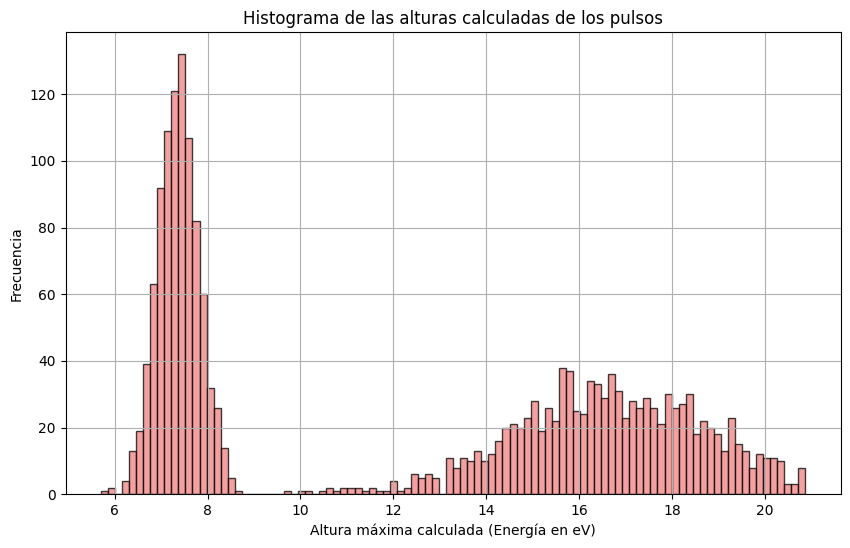

In [24]:
# Determinar las alturas máximas de los pulsos generados
alturas_calculadas = [max(pulso) for pulso in pulsos]

# Visualizar histograma de las alturas calculadas
plt.figure(figsize=(10, 6))
plt.hist(alturas_calculadas, bins=100, alpha=0.75, edgecolor='black', color='lightcoral')
plt.xlabel('Altura máxima calculada (Energía en eV)')
plt.ylabel('Frecuencia')
plt.title('Histograma de las alturas calculadas de los pulsos')
plt.grid()
plt.show()

### Concatenando los pulsos para generar una unica señal

In [25]:
# --- Exportar el vector a un archivo CSV ---
filename = "alturas.csv"
df = pd.DataFrame(alturas_calculadas, columns=["Values"])  # Crear un DataFrame
df.to_csv(filename, index=False)  # Exportar a CSV sin el índice
print(f"Vector exportado a {filename}")

Vector exportado a alturas.csv
